In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import time

### First we set a seed for deterministic output and ease of reproducability.

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # ensures deterministic algorithms
    torch.backends.cudnn.benchmark = False     # can slow down, but more reproducible

set_seed(42)

### Now we create the RNN and DataSet classes for our weather predictions.

In [3]:
class WeatherRNN(nn.Module):
  def __init__(self, input_size:int, hidden_size:int, output_size:int, num_layers:int=1, rnn_type:str='RNN', dropout:float=0.0):
    super().__init__()

    # potential RNN classes
    rnn_options = {"RNN": nn.RNN,
                   "LSTM": nn.LSTM,
                   "GRU": nn.GRU}

    if rnn_type not in rnn_options:
      raise ValueError(f'rnn_type must be one of {list(rnn_options.keys())}')

    # force dropout to be 0 if num_layers == 1
    dropout = dropout if num_layers > 1 else 0.0

    self.rnn_type = rnn_type

    # define the rnn
    self.rnn = rnn_options[rnn_type](input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    # fully connected linear layers
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, h0=None):
    batch_size = x.size(0)
    out, _ = self.rnn(x) if h0 is None else self.rnn(x, h0)
    out = self.fc(out[:,-1,:])
    return out, _

In [4]:
class TimeSeries(Dataset):
  def __init__(self, data, seq_len):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.seq_len = seq_len

  def __len__(self):
    # subtract self.seq_len to account for data where previous sequence is unknown
    return len(self.data) - self.seq_len

  def __getitem__(self, start_idx):
    end_idx = start_idx + self.seq_len

    # generate the sequence of size seq_len and the target that follows directly after
    X_seq = self.data[start_idx:end_idx].unsqueeze(-1) # (seq_len x 1)
    y = self.data[end_idx].unsqueeze(-1) # (1,)

    return X_seq, y

### Now we can load our training data. For now, we will only predict the next day's maximum temperature using the previous week's maximum temperatures.

In [5]:
def read_data(paths):
    # create array to store each dataframe created
    df_arr = []

    # recover necessary data from each csv file
    for f in paths:
        df = pd.read_csv(f)
        df["DATE"] = pd.to_datetime(df["DATE"])
        df.set_index("DATE", inplace=True)
        df = pd.DataFrame(df["TMAX"])

        # add dataframe to array
        df_arr.append(df)

    return df_arr

f_paths = ["../Project1/split_data/APA_weather_train.csv",
           "../Project1/split_data/APA_weather_validation.csv",
           "../Project1/split_data/APA_weather_test.csv"]

train_data, validation_data, test_data = read_data(f_paths)

### Before creating the dataset and dataloader, we need to normalize the data using `MinMaxScaler()`. We can create a new colum in the dataframe called `"NORM"` to store the normalized values of the maximum daily temperatures.

In [6]:
def normalize(df_arr, transformation):
    # array to store normalized data
    norm_df_arr = []

    # normalize data and append to array
    for df in df_arr:
        df["NORM"] = transformation(df["TMAX"].values.reshape(-1,1))
        norm_df_arr.append(df)
    
    return norm_df_arr

def load_data(data_norm, seq_len, batch_size=32, shuffle=False, drop_last=True):
    dataset = TimeSeries(data_norm.values, seq_len=seq_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)

    return dataset, dataloader


scaler = MinMaxScaler()
seq_len = 7
train_data, validation_data, test_data = normalize([train_data, validation_data, test_data], scaler.fit_transform)

train_dataset, train_loader = load_data(train_data["NORM"], seq_len=seq_len)
validation_dataset, validation_loader = load_data(validation_data["NORM"], seq_len=seq_len)
test_dataset, test_loader = load_data(test_data["NORM"], seq_len=seq_len)

### Now we will set the device and the model's hyperparameters. The we will be training a LSTM model with an input size of 1 (the maximum temperature) and an output size of 1 (the maximum temperature). The size of the hidden state will be set to 16. We will use the MSE as our loss function with the adam optimizer and a learning rate of $\eta=0.001$. We will train the model for 100 epochs.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WeatherRNN(input_size=1, hidden_size=16, output_size=1, num_layers=1, rnn_type="LSTM")

In [8]:
def train_RNN(model, train_dataloader, validation_dataloader, num_epochs=50, 
              criterion=nn.MSELoss(), optimizer=optim.Adam, eta=1.e-3, device=device):
    
    model = model.to(device)

    training_loss = np.empty(num_epochs) * np.nan
    validation_loss = np.empty(num_epochs) * np.nan

    optimizer = optimizer(model.parameters(), lr=eta)

    print("Training ...")

    start_time = time.time()

    for epoch in range(num_epochs):
        # training and validation loss for each epoch
        train_epoch_loss = 0
        validation_epoch_loss = 0

        # reset hidden state after each epoch
        hidden = None

        model.train()
        for x_batch, y_batch in train_dataloader:
            if hidden is not None:
                if model.rnn_type == "LSTM":
                    hidden = (hidden[0].detach(), hidden[1].detach())
                else:
                    hidden = hidden.detach()

            out, hidden = model(x_batch, hidden)
            loss = criterion(out, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
        
        # average loss over each batch
        train_epoch_loss /= len(train_dataloader)

        # save losses for plotting later
        training_loss[epoch] = train_epoch_loss

        
        model.eval()
        # reset hidden state
        hidden = None
        with torch.no_grad():
            for x_batch, y_batch in validation_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if hidden is not None:
                    if model.rnn_type == "LSTM":
                        hiden = (hidden[0].detach(), hidden[1].detach())
                    else:
                        hidden = hidden.detach()

                out, hidden = model(x_batch, hidden)
                loss = criterion(out, y_batch)
                validation_epoch_loss += loss.item()
            
            validation_epoch_loss /= len(validation_dataloader)
        
        validation_loss[epoch] = validation_epoch_loss

        if epoch % 10 == 9:
            print(f'Epoch {epoch+1}: \n\tTraining Loss = {train_epoch_loss}\n\tValidation Loss = {validation_epoch_loss}')

    end_time = time.time()

    print("Done!")
    print(f'Total time (seconds): {end_time-start_time}')

    return training_loss, validation_loss


# train the RNN
training_loss, validation_loss = train_RNN(model, train_loader, validation_loader)

Training ...
Epoch 10: 
	Training Loss = 0.009944503387922177
	Validation Loss = 0.012010477353161311
Epoch 20: 
	Training Loss = 0.008490670713891061
	Validation Loss = 0.010033879028496277
Epoch 30: 
	Training Loss = 0.008398242299849897
	Validation Loss = 0.009924125785747653
Epoch 40: 
	Training Loss = 0.00836598655998545
	Validation Loss = 0.00990599112051046
Epoch 50: 
	Training Loss = 0.008306833391905017
	Validation Loss = 0.009876798537066755
Done!
Total time (seconds): 34.82254505157471


### Let's visualize how the training loss changes as we train the model.

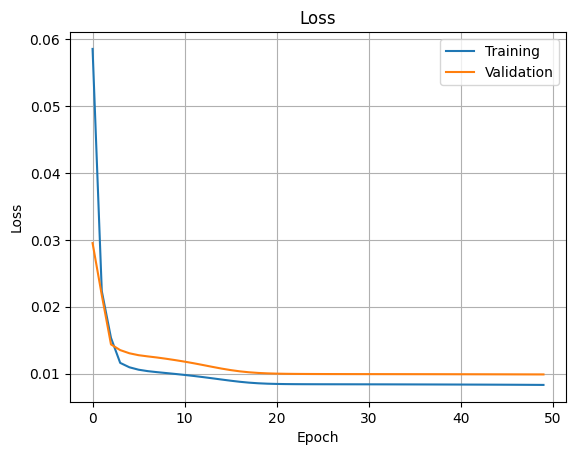

In [9]:
plt.plot(training_loss, label="Training")
plt.plot(validation_loss, label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

### Now that the model has finished training, let's see what it's predictions are on the training and validation datasets. We'll feed the training and validation data into the model and store the predictions in a new column of their respective dataframes called "Prediction".

In [10]:
def test_RNN(model, dataloader, seq_len, device=device):
    # store predictions in an array
    predictions = np.empty([len(dataloader)+seq_len, 1])

    # first seq_len entries not available
    predictions[:seq_len] = np.nan

    model.eval()

    with torch.no_grad():
        idx = seq_len
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            
            # make prediction
            out, _ = model(x)

            # add prediction to array
            predictions[idx] = out.item()
            idx += 1

    return predictions


# see how the final model performs on the training and validation data
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
train_prediction = scaler.inverse_transform(test_RNN(model, train_loader, seq_len=seq_len))

validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
validation_prediction = scaler.inverse_transform(test_RNN(model, validation_loader, seq_len=seq_len))

train_data["Predicted"] = train_prediction
train_data.rename(columns={"TMAX": "True"}, inplace=True)

validation_data["Predicted"] = validation_prediction
validation_data.rename(columns={"TMAX": "True"}, inplace=True)

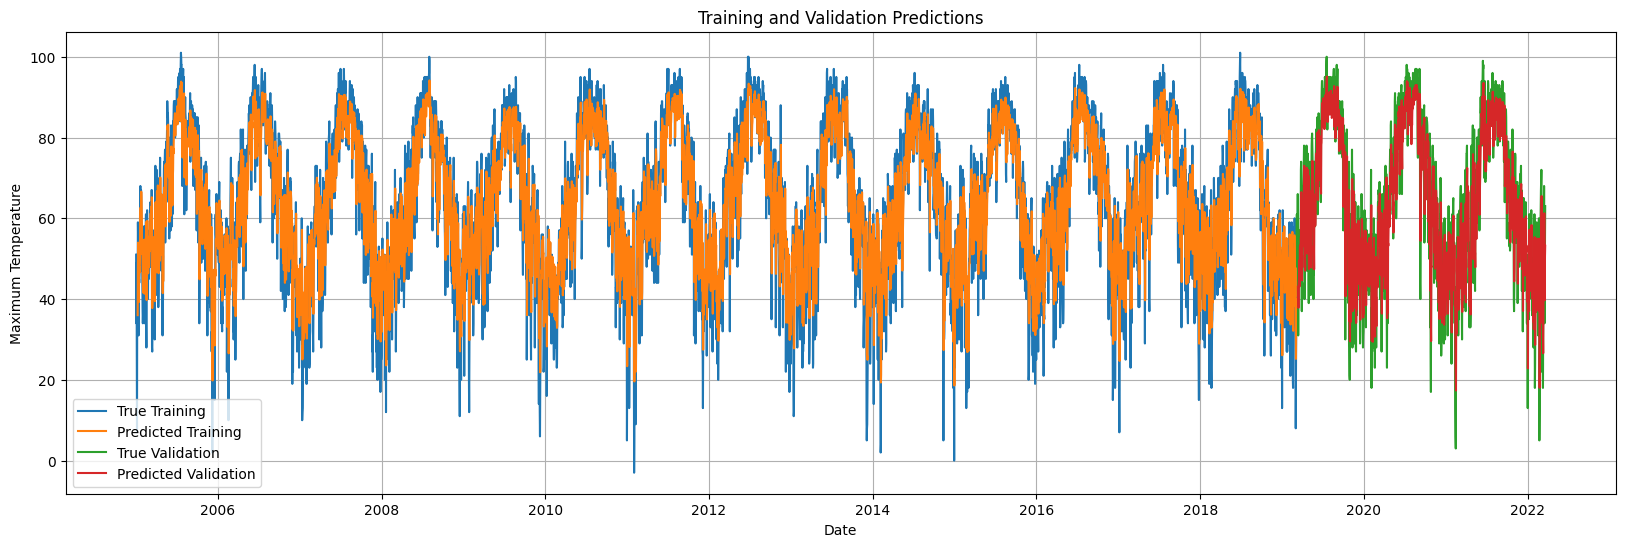

In [11]:
def plot_predictions(df_arr, columns, samples, title, figsize=(8,6)):
    fig = plt.figure(figsize=figsize)
    for i in range(len(df_arr)):
        for col in columns:
            df = df_arr[i]
            plt.plot(df[col], label=f'{col} {samples[i]}')
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Maximum Temperature")
    plt.legend()
    plt.grid()
    plt.close()
    return fig

plot_predictions([train_data, validation_data], ["True", "Predicted"], ["Training", "Validation"], "Training and Validation Predictions", figsize=(20,6))

### Our model appears to underpredict high temperatures and overpredict low temperatures. Let's visualize the distribution of the absolute errors.

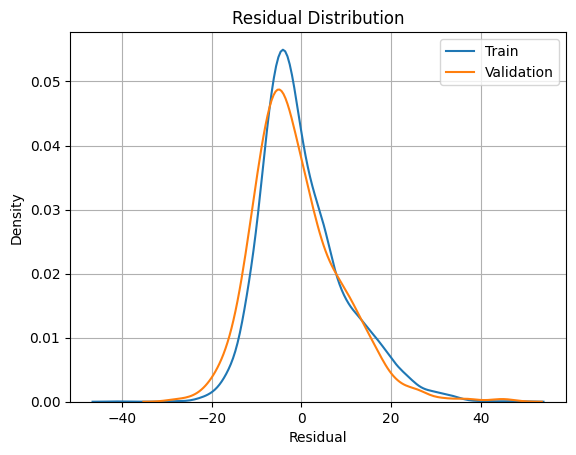

In [12]:
def signed_err(df):
    return (df["Predicted"] - df["True"])

train_abs_err = signed_err(train_data)
validation_abs_err = signed_err(validation_data)
sns.kdeplot(signed_err(train_data), label="Train")
sns.kdeplot(signed_err(validation_data), label="Validation")
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.grid()
plt.legend()
plt.show()

### The residuals are relatively normally distributed around zero which is a good sign that our model does not tend to have a bias. However, we see that it is not uncommon for our predictions to be off by more than $10^\circ$ F. Let's check out the RMSE, MAE, and bias for the predictions of the training and validation datasets.

In [13]:
train_rmse = root_mean_squared_error(train_data["True"].values[seq_len:], train_data["Predicted"].values[seq_len:])
validation_rmse = root_mean_squared_error(validation_data["True"].values[seq_len:], validation_data["Predicted"].values[seq_len:])

train_mae = mean_absolute_error(train_data["True"].values[seq_len:], train_data["Predicted"].values[seq_len:])
validation_mae = mean_absolute_error(validation_data["True"].values[seq_len:], validation_data["Predicted"].values[seq_len:])

train_bias = signed_err(train_data).mean(skipna=True)
validation_bias = signed_err(validation_data).mean(skipna=True)

metrics = pd.DataFrame({"RMSE": [train_rmse, validation_rmse],
                        "MAE": [train_mae, validation_mae],
                        "Bias": [train_bias, validation_bias]},
                        index=["Train", "Validation"]).T

metrics

,Train,Validation
RMSE,9.514703,9.809595
MAE,7.318776,7.728459
Bias,0.315058,-1.115459


### Next we can find out how well it performs on unseen data. As with the training data, we start by loading it from the csv file.

In [15]:
test_data = pd.read_csv('../Project1/merged_data/denver_weather_test.csv')
test_data["DATE"] = pd.to_datetime(test_data["DATE"])
test_data.set_index("DATE", inplace=True)
test_data = test_data[test_data["STATION"]==0]
test_data = pd.DataFrame(test_data["TMAX"])
test_data["NORM"] = scaler.transform(test_data["TMAX"].values.reshape(-1,1))
print(test_data.head())

test_dataset = TimeSeries(test_data["NORM"].values, seq_len=seq_len)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

            TMAX      NORM
DATE                      
2022-04-03  50.0  0.519608
2022-04-04  65.0  0.666667
2022-04-05  60.0  0.617647
2022-04-06  46.0  0.480392
2022-04-07  50.0  0.519608


### Now we can test its performance on unseen data.

In [16]:
# test the model on unseen data and rescale
test_predictions = scaler.inverse_transform(test_RNN(model, test_loader, seq_len=seq_len))

test_data["Predicted"] = test_predictions


test_data.rename(columns={"TMAX": "True"}, inplace=True)
test_data[seq_len:]

,True,NORM,Predicted
DATE,,,
2022-04-10,58.0,0.598039,69.225764
2022-04-11,64.0,0.656863,58.076305
2022-04-12,58.0,0.598039,64.652761
2022-04-13,38.0,0.401961,59.859577
2022-04-14,56.0,0.578431,47.159595
...,...,...,...
2025-03-30,52.0,0.539216,61.990752
2025-03-31,61.0,0.627451,59.468721
2025-04-01,51.0,0.529412,65.191524


### Lets plot the predictions of the model for the test data

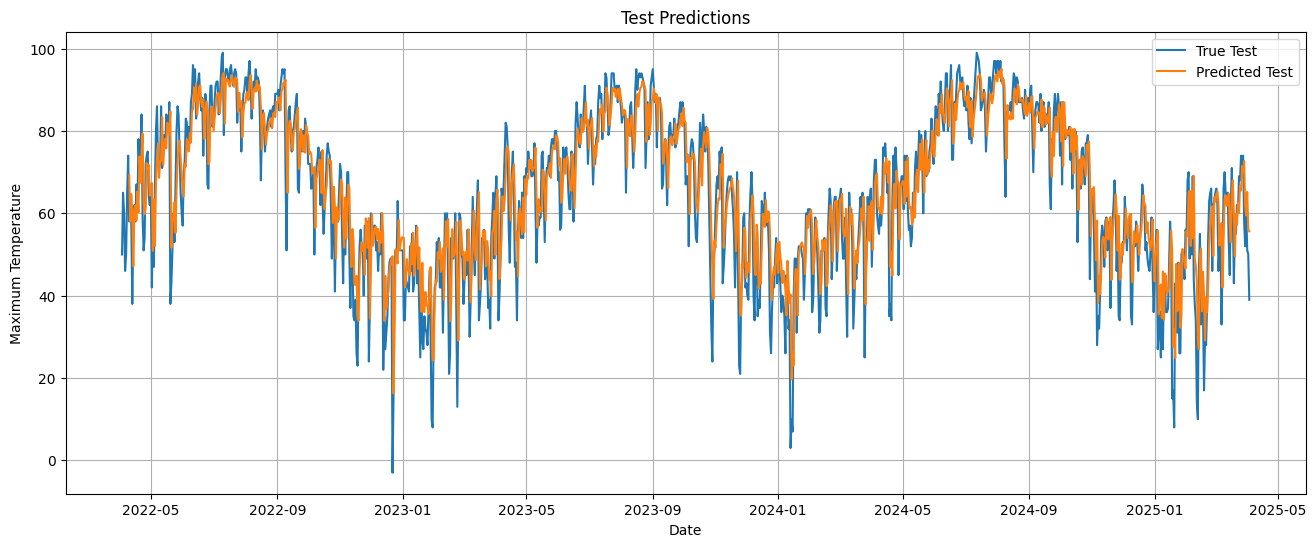

In [17]:
plot_predictions([test_data], ["True", "Predicted"], ["Test"], "Test Predictions", figsize=(16,6))

### Again, we can visualize the distribution of the residuals using the density plot.

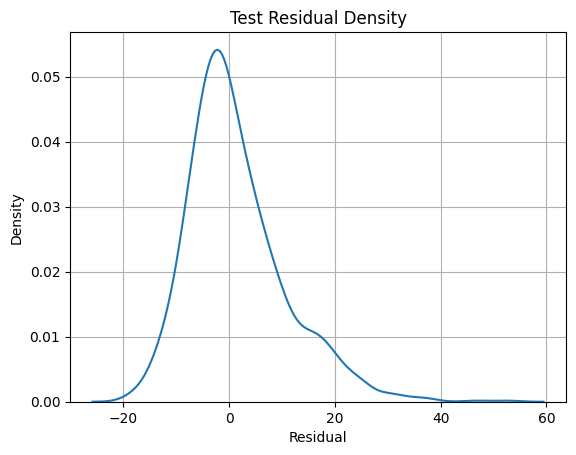

In [18]:
test_abs_err = signed_err(test_data)

sns.kdeplot(test_abs_err)
plt.title("Test Residual Density")
plt.xlabel("Residual")
plt.grid()
plt.show()

### Again, we find a relatively normal distribution centered near zero. Let's see what the RMSE, MAE, and bias of the test predictions look like after being transformed back to their original units.

In [19]:
test_rmse = root_mean_squared_error(test_data["True"].values[seq_len:], test_data["Predicted"].values[seq_len:])
test_mae = mean_absolute_error(test_data["True"].values[seq_len:], test_data["Predicted"].values[seq_len:])
test_bias = signed_err(test_data).mean()

metrics["Test"] = [test_rmse, test_mae, test_bias]

metrics

,Train,Validation,Test
RMSE,9.514703,9.809595,9.379888
MAE,7.318776,7.728459,6.894473
Bias,0.315058,-1.115459,1.407130


### Overall, we find relatively similar performance between the three datasets. The next step is to compare how different types of models (RNN vs LSTM vs GRU) perform with different parameters (such as optimizers) on multiple datasets. This will be done in [Project 4](https://github.com/kennethwirjadisastra/Stat155/tree/main/Project4).